## Семинар 4: "Сверточные сети"

ФИО: Хапкин Артем Владимирович

In [253]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split
import torch
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

### Часть 1: Свертка

#### Одномерные сигналы
Начнем с одномерных сигналов — например, это могут быть различные временные ряды. 

<i>1.1 Реализуйте функцию, вычисляющую одномерную свертку.</i>

In [6]:
def t_convolve(signal, kernel):
    signal_convolved = np.zeros(len(signal)-len(kernel)+1)
    # 1. не забудьте перевернуть ядро!
    # 2. необходимо реализовать свертку без отступов, т.е. 
    #   размер результирующего сигнала должен быть меньше входного.
    
    ##### YOUR CODE HERE #####
    size = len(signal)-len(kernel)+1
    for i in range(size):
        signal_convolved[i] = np.sum([signal[i+j]*kernel[len(kernel) - 1 - j] for j in range(len(kernel))])
            
    
    return signal_convolved

In [10]:
signal = np.array([1,1,1,1,1,1])
kernel = np.array([1,2])
type(t_convolve(signal, kernel))



numpy.ndarray

Проверим правильность реализации, сравнив с реализацией из scipy

In [8]:
from scipy.signal import convolve

signal = np.random.rand(100)
kernel = np.random.rand(5)
t_result = t_convolve(signal, kernel)
b_result = convolve(signal, kernel, mode='valid')

a = np.testing.assert_allclose(t_result, b_result)
print (t_result == b_result)
#Вроде все правильно

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]


Посмотрим как операция свертки может помочь нам убрать шум из сигнала

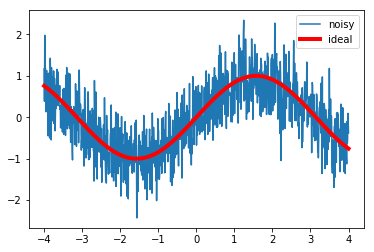

In [9]:
x = np.linspace(-4, 4, 1000)
signal = np.sin(x)
noisy_signal = signal + np.random.randn(signal.shape[0])*0.5
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.legend(loc=0)


Для подавления шума можно использовать усреднение значений сигнала в окрестности каждой точки (см. ЗБЧ). Вы можете убедиться, что такая операция может быть реализована при помощи свертки данных с ядром, $[\frac 1w, \frac 1w, ..., \frac 1w]$, где $w$ — размер окна.

<i>1.2  Вычислите свертку сигнала с ядром $[0.2, 0.2, 0.2, 0.2, 0.2]$ </i>

In [6]:
np.array([0.2 for i in range(5)])

array([ 0.2,  0.2,  0.2,  0.2,  0.2])

In [23]:
k = 20
denoised_signal = t_convolve(signal, np.array([ 1/5 for i in range(k)])) ### YOUR CODE HERE #####
denoised_signal.shape
x[2:-2].shape

(996,)

5
(991,)
(990,)


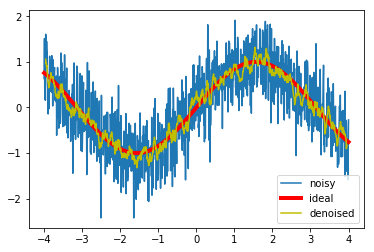

In [53]:
x = np.linspace(-4, 4, 1000)
w = int(k/2)
print (w)
signal = np.sin(x)
noisy_signal = signal + np.random.randn(signal.shape[0])*0.5
denoised_signal = t_convolve(noisy_signal, np.array([ 1/k for i in range(k)]))
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
print (denoised_signal.shape)
print (x[w:-w].shape)
plt.plot(x[w:-w], denoised_signal[1:], 'y', label='denoised')
plt.legend(loc=0)

(1000,)

Заметим, что уровень шума значительно снизился! Попробуйте подобрать такую ширину окна, чтобы востановленный сигнал был наиболее похож на исходный.

<i> 1.3 Подберите размер окна <i>

In [9]:
### YOUR CODE HERE #####

g = lambda x: (sum([(x[i] - np.sin(x[i])) **2 for i in range(len(x))]))**(0.5)/len(x)  
flag = []
t = 0
for i in range(5, 200):
    t+=1
    x = t_convolve(noisy_signal, np.array([1/i for j in range(i)]))
    flag.append(g(x))
print (np.array(flag).argmin())


194


#### Многомерные сигналы
Перейдем теперь к черно-белым и цветным изображениям. Для ЧБ изображений имеем двумерный сигнал, для цветных — трехмерный (высота x ширина x каналы).

Для цветных изображений количество каналов ядра обычно совпадает с количеством каналов изображения. Таким образом, в результате получается черно-белое изображение.

<i>Для вычисления многомерных сверток используйте функцию convolve из from scipy.signal import convolve</i>

<i>1.4 Найдите в вашей любимой поисковой системе веса каналов для перевода цветного изображения в черно-белое. Постройте фильтр, который будет переводить цветное изображение в ЧБ</i>

In [10]:
def convert(img, coefs=np.array([0.299, 0.587, 0.114])):
    return np.dot(img[..., :3], coefs)


<i>1.5 На примере любого цветного изображения покажите результат его свертки с фильтром из предыдущего задания.</i>

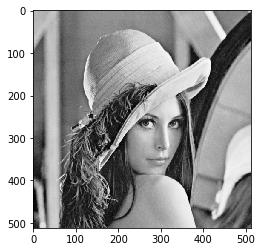

In [11]:
image = plt.imread('Lenna.png')
plt.imshow(image)
plt.imshow(convert(image), cmap=plt.cm.Greys_r)

Операция свертки также позволяет находить границы на изображении. Для этого можно использовать, например, фильтр Собеля.

<i>1.6 Задайте ядро фильтра Собеля и продемонстрируйте результат его применения к любому цветному изображению.</i>

In [12]:
from skimage.color import rgb2gray
def sobel(img):
    
    sobel_kernel_h = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
    sobel_kernel_v = np.transpose(sobel_kernel_h)
    conv_x = convolve(img,sobel_kernel_h)
    conv_y = convolve(img,sobel_kernel_v)
    edge = np.sqrt(conv_x**2 + conv_y**2)

    return edge

Получим градиентную Лену.

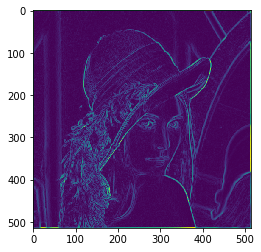

In [14]:
plt.imshow(sobel(rgb2gray(image)))


В сверточных нейронных сетях каждый слой использует несколько фильтров. Допустим, у нас было изображение с тремя каналами (количество входных каналов). Рассмотрим банк из четырех фильтров (количество выходных каналов). Тогда изначально будет вычислена свертка с каждым фильтром — получим 4 ЧБ изображения. Теперь соединим их в одно, интерпретируя каждое ЧБ изображение как канал цветного: RGB$\alpha$.

<i>1.7 Реализуйте операцию свертки с банком фильтров (filter bank).</i>

In [15]:


def t_convolve_bank(signal, kernel):
    assert signal.ndim == kernel.ndim+1
    ##### YOUR CODE HERE #####
    out = np.zeros((signal.shape[0],signal.shape[1], signal.ndim+1))
    out[...,0] = convolve(kernel[0].reshape(1,1,-1), signal, mode='valid').reshape(bw_image.shape[0]-2,bw_image.shape[1]-2)
    out[...,1] = convolve(signal, kernel[1].reshape(1,1,-1), mode='valid').reshape(bw_image.shape[0]-2,bw_image.shape[1]-2)
    out[...,2] = convolve(signal, kernel[2].reshape(1,1,-1), mode='valid').reshape(bw_image.shape[0]-2,bw_image.shape[1]-2)
    out[...,3] = convolve(signal, kernel[3].reshape(1,1,-1), mode='valid').reshape(bw_image.shape[0]-2,bw_image.shape[1]-2)
    return out

<i>1.8 Задайте банк фильтров, меняющий порядок следования каналов с RGB на BGR.</i>

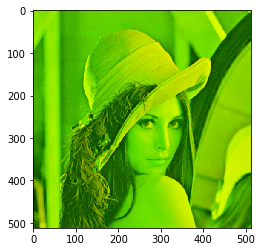

In [17]:
##### YOUR CODE HERE #####
bank_filter = np.array(
      [[1, 0, 0],
       [0, 1, 0],
       [0, 0, 0],
       [0, 0, 1]])

bw_image = sobel(rgb2gray(image))
bgr = t_convolve_bank(image, bank_filter)
plt.imshow(bgr[...,[1,3,2]])


<i>1.9 Продемонстрируйте результат свертки любого цветного изображения с банком фильтров из предыдущего пункта.</i>

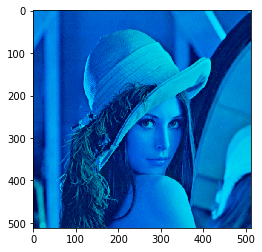

In [18]:
##### YOUR CODE HERE #####
# Не забудьте, что после свертки вы скорее всего получите тензор типа float. 
# Чтобы imshow нормально отобразил результат, надо привести его к типу uint8 (нпр., при помощи .astype('uint8'))

plt.imshow(bgr[...,[2,1,3]])


В процессе обучения сверточных нейронных сетей настраиваются веса элементов фильтр банка. Это позволяет не заниматься подбором коэффициентов "руками", а задавать лишь размер ядра: ширину, высоту, количество входных и выходных каналов. В итоге получаем четырехмерный массив (тензор).

### Часть 2: Пулинг

При использовании сверточных слоев принято использовать слои пулинга. Эта операция позволяет уменьшить пространственные размерности изображения и избавиться от избыточности.

<i>2.1 Реализуйте операции пулинга для цветных изображений</i>

In [239]:
import copy
import random
from scipy.ndimage.filters import maximum_filter, median_filter, gaussian_filter

def maxpool(img, window_size):
    assert(img.ndim == 3)
    temp_win = np.zeros((image.shape[0]//2, image.shape[1]//2, 3))

    temp = copy.deepcopy(img)
    for k in range(0, img.ndim):
        a=temp[...,k]
        for j in range(0, img.shape[0]//2):
            for i in range(0, img.shape[1]//2):
                temp_win[i][j][k] = np.max(a[2*i:2*i+2, 2*j:2*j+2])
       
    return temp_win



In [242]:

def medianpool(img, window_size):
    assert(img.ndim == 3)
    temp_win = np.zeros((image.shape[0]//2, image.shape[1]//2, 3))

    temp = copy.deepcopy(img)
    for k in range(0, img.ndim):
        a=temp[...,k]
        for j in range(0, img.shape[0]//2):
            for i in range(0, img.shape[1]//2):
                temp_win[i][j][k] = np.median(a[2*i:2*i+2, 2*j:2*j+2])
       
    return temp_win

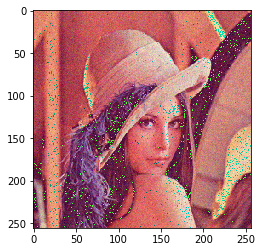

In [244]:
plt.imshow(medianpool(zzz,2))


In [219]:
def salt_and_pepper(image):
    row,col,ch= image.shape
    return image + np.random.normal(1,0.1,(row,col,ch)).reshape(row,col,ch)



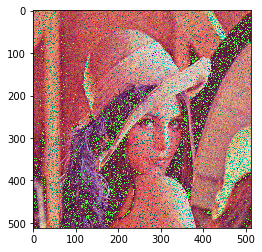

In [220]:
image = plt.imread('Lenna.png')
zzz = salt_and_pepper(image)
plt.imshow(zzz)

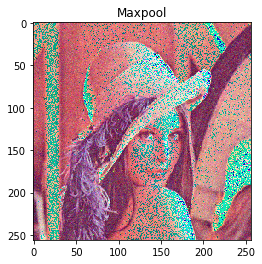

In [245]:
plt.imshow(maxpool(zzz,4))
plt.title('Maxpool')

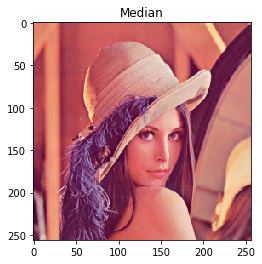

In [246]:
plt.imshow(medianpool(image,2))
plt.title('Median')

Вроде медианный справляется лучше.

### Часть 3: Сверточная сеть на pyTorch

pyTorch предоставляет модули свертки и пулинга. Попробуем построить сеть и натренировать ее на данных MNIST. Для загрузки данных воспользуйтесь кодом со второго семинара.

Воспользуемся кодом с предыдущего семинара, чтобы обучить сверточную сеть на данных MNIST. Попробуем две архитектуры: 
2. input -> 8 conv 3x3 -> ReLU -> maxpool -> 16 conv 3x3 -> ReLU -> ravel -> linear -> softmax
1. input -> 8 conv 3x3 -> ReLU -> 16 conv 3x3 -> ReLU -> maxpool -> 32 conv 3x3 -> ravel -> linear -> softmax

Здесь запись "c conv KxK" означает то, что на выходе должно получиться c каналов, а размер ядра — KxK

Ниже приведен пример сети. <i>(Документация: http://pytorch.org/docs/)</i>

In [254]:
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)


IndexError: index 16 is out of bounds for axis 0 with size 16

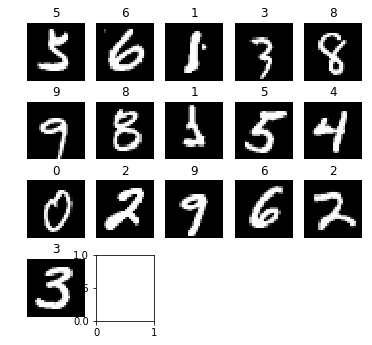

In [255]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    #print (X.shape)
    pass

for X, y in test_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    print (X.shape)
    pass

plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    if (i == 1):
        print (X[i].shape)
    plt.axis('off')



In [250]:
class myConvNet(nn.Module):
    def __init__(self):
        super(myConvNet, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(1, 8, 3), nn.ReLU(), nn.MaxPool2d(2), 
                                         nn.Conv2d(8, 16, 3), nn.ReLU())
        self.linear_layers = nn.Sequential(nn.Linear(11 * 11 * 16, 10), nn.LogSoftmax())
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x




<i>3.1 Обучите сверточные сети с архитектурами (1) и (2). Какое качество удалось получить на тестовой выборке? Какой результат получался на полносвязной нейронной сети?</i>

# Архитектура 1.

In [251]:
from tqdm import tqdm
network1 = myConvNet()
loss_fn1 = torch.nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(network1.parameters(), lr=0.001)

In [268]:
flag_final = []

for epoch in tqdm(range(10)):
    tl = -1
    flag = []

    for X, y in train_loader:
        #print ("shape = ", X.shape)
    
        output = network1.forward(Variable(X))
        
        loss = loss_fn1(output, Variable(y, requires_grad=False))

        optimizer1.zero_grad()
        loss.backward()
        optimizer1.step()
        
        tl = max(tl, loss.data[0])
        flag.append(tl)
    

    pred = np.array([])
    real = np.array([])



    for X, y in test_loader:
        output = network1.forward(Variable(X))
        
        pred = np.append(pred, output.data.numpy().argmax(axis = 1))
        real = np.append(real, y.numpy())


    flag_final.append(np.array(flag).mean())
    print ("Error is ", np.array(flag).mean())
    print ("Accuracy score is", accuracy_score(pred, real))
    

 10%|█         | 1/10 [00:15<02:21, 15.68s/it]

Error is  0.683432114275
Accuracy score is 0.9843


 20%|██        | 2/10 [00:31<02:07, 15.94s/it]

Error is  0.498575007881
Accuracy score is 0.9874


 30%|███       | 3/10 [00:48<01:52, 16.05s/it]

Error is  0.460026171751
Accuracy score is 0.9863


 40%|████      | 4/10 [01:04<01:37, 16.23s/it]

Error is  0.428012104174
Accuracy score is 0.9878


 50%|█████     | 5/10 [01:20<01:20, 16.04s/it]

Error is  0.382559601557
Accuracy score is 0.9869


 60%|██████    | 6/10 [01:36<01:04, 16.01s/it]

Error is  0.298678481172
Accuracy score is 0.9867


 70%|███████   | 7/10 [01:51<00:47, 15.99s/it]

Error is  0.366484745944
Accuracy score is 0.9886


 80%|████████  | 8/10 [02:07<00:31, 15.95s/it]

Error is  0.268952715745
Accuracy score is 0.9872


 90%|█████████ | 9/10 [02:22<00:15, 15.80s/it]

Error is  0.249650992214
Accuracy score is 0.9857


100%|██████████| 10/10 [02:36<00:00, 15.65s/it]

Error is  0.324213791313
Accuracy score is 0.988


[0.68343211427529649,
 0.49857500788072745,
 0.46002617175107202,
 0.4280121041742464,
 0.38255960155725477,
 0.29867848117202522,
 0.3664847459435463,
 0.26895271574457486,
 0.24965099221405884,
 0.324213791312774]

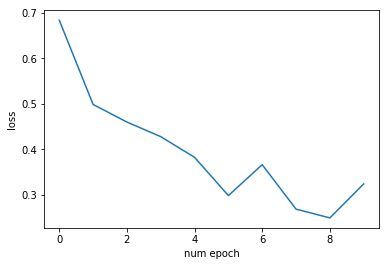

In [269]:
plt.figure()
plt.plot(flag_final)
plt.xlabel('num epoch')
plt.ylabel('loss')
flag_final

<i>3.2 На каких объектах сеть ошибается сильнее всего?</i>

In [151]:
##### YOUR CODE HERE #####

predicted_losses = np.zeros(len(train_dataset))
predicted_cls = np.zeros(len(train_dataset))

for i in tqdm(range(len(train_dataset))):
        #print (i)
        X, y = train_dataset[i]
        output = network1.forward(Variable(torch.from_numpy(np.array([X.numpy()]))))
        #print (X.numpy().shape)
        #print (np.array([X.numpy()]))
        #break
        loss = loss_fn1(output, Variable(torch.from_numpy(np.array([y])), requires_grad=False))
        predicted_losses[i] = loss.data[0]
        predicted_cls[i] = output.data.numpy().argmax()
        

100%|██████████| 60000/60000 [00:28<00:00, 2117.97it/s]


In [152]:
predicted_args = predicted_losses.argsort()[-35:]
predicted_cls = predicted_cls[predicted_args]

In [155]:
predicted_cls

array([ 3.,  4.,  4.,  4.,  4.,  3.,  9.,  9.,  7.,  4.,  5.,  1.,  9.,
        2.,  7.,  4.,  3.,  2.,  0.,  9.,  7.,  4.,  7.,  2.,  7.,  7.,
        2.,  5.,  2.,  6.,  2.,  5.,  1.,  7.,  8.])

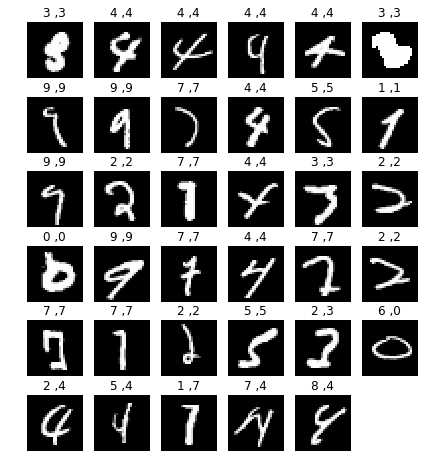

In [157]:
plt.figure(figsize=(7, 8))
for i in range(len(predicted_args)):
    plt.subplot(6, 6, i+1)
    plt.imshow(train_dataset[predicted_args[i]][0].numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    
    plt.title(str(int(predicted_cls[i])) + ' ,' + str(train_dataset[predicted_args[i]][1])  )
    plt.axis('off')
    

# Архитектура 2

In [166]:
class myConvNet2(nn.Module):
    def __init__(self):
        super(myConvNet2, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(1, 8, 3), nn.ReLU(), 
                                         nn.Conv2d(8, 16, 3), nn.ReLU(),
                                        nn.MaxPool2d(2), nn.Conv2d(16, 32, 3))
        self.linear_layers = nn.Sequential(nn.Linear(32 * 10 * 10, 10), nn.LogSoftmax())
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x



In [256]:
from sklearn.metrics import accuracy_score
network2 = myConvNet()
loss_fn2 = torch.nn.CrossEntropyLoss()
optimizer2 = torch.optim.Adam(network2.parameters(), lr=0.001)

In [257]:
flag_final = []

for epoch in tqdm(range(10)):
    flag = []

    for X, y in train_loader:
        #print ("shape = ", X.shape)
        flag = []
    
        output = network2.forward(Variable(X))
        
        loss = loss_fn1(output, Variable(y, requires_grad=False))

        optimizer2.zero_grad()
        loss.backward()
        optimizer2.step()
        
        tl = max(-1, loss.data[0])
        flag.append(tl)
    

    pred = np.array([])
    real = np.array([])



    for X, y in test_loader:
        output = network2.forward(Variable(X))
        
        pred = np.append(pred, output.data.numpy().argmax(axis = 1))
        real = np.append(real, y.numpy())


    flag_final.append(np.array(flag).mean())
    print ("Error is ", np.array(flag).mean())
    print ("Accuracy score is", accuracy_score(pred, real))
    


  0%|          | 0/10 [00:00<?, ?it/s]
Exception in thread Thread-6:
Traceback (most recent call last):
  File "/home/temkahap/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/temkahap/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/temkahap/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

 10%|█         | 1/10 [00:15<02:18, 15.37s/it]

Error is  0.190231651068
Accuracy score is 0.9823


 20%|██        | 2/10 [00:30<02:02, 15.29s/it]

Error is  0.025942068547
Accuracy score is 0.9837


 30%|███       | 3/10 [00:44<01:43, 14.84s/it]

Error is  0.00275996606797
Accuracy score is 0.9858


 40%|████      | 4/10 [00:59<01:28, 14.81s/it]

Error is  0.0805002301931
Accuracy score is 0.9856


 50%|█████     | 5/10 [01:14<01:14, 14.89s/it]

Error is  0.00924675539136
Accuracy score is 0.9867


 60%|██████    | 6/10 [01:29<00:59, 14.94s/it]

Error is  0.00146223593038
Accuracy score is 0.9881


 70%|███████   | 7/10 [01:46<00:45, 15.17s/it]

Error is  0.0444913953543
Accuracy score is 0.9877


 80%|████████  | 8/10 [02:00<00:30, 15.11s/it]

Error is  0.00378010817803
Accuracy score is 0.9869


 90%|█████████ | 9/10 [02:16<00:15, 15.17s/it]

Error is  0.149118289351
Accuracy score is 0.9882


100%|██████████| 10/10 [02:32<00:00, 15.21s/it]

Error is  0.0301927998662
Accuracy score is 0.9883


[0.19023165106773376,
 0.025942068547010422,
 0.002759966067969799,
 0.080500230193138123,
 0.0092467553913593292,
 0.0014622359303757548,
 0.044491395354270935,
 0.0037801081780344248,
 0.14911828935146332,
 0.030192799866199493]

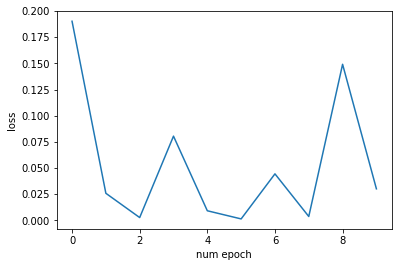

In [262]:
plt.figure()
plt.plot(flag_final)
plt.xlabel('num epoch')
plt.ylabel('loss')
flag_final

In [170]:
##### YOUR CODE HERE #####

predicted_losses = np.zeros(len(train_dataset))
predicted_cls = np.zeros(len(train_dataset))

for i in tqdm(range(len(train_dataset))):
        #print (i)
        X, y = train_dataset[i]
        output = network1.forward(Variable(torch.from_numpy(np.array([X.numpy()]))))
        #print (X.numpy().shape)
        #print (np.array([X.numpy()]))
        #break
        loss = loss_fn1(output, Variable(torch.from_numpy(np.array([y])), requires_grad=False))
        predicted_losses[i] = loss.data[0]
        predicted_cls[i] = output.data.numpy().argmax()
        

100%|██████████| 60000/60000 [00:31<00:00, 1921.26it/s]


In [171]:
predicted_args = predicted_losses.argsort()[-35:]
predicted_cls = predicted_cls[predicted_args]

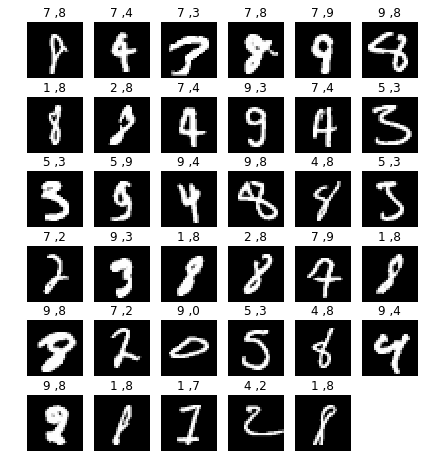

In [172]:
plt.figure(figsize=(7, 8))
for i in range(len(predicted_args)):
    plt.subplot(6, 6, i+1)
    plt.imshow(train_dataset[predicted_args[i]][0].numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    
    plt.title(str(int(predicted_cls[i])) + ' ,' + str(train_dataset[predicted_args[i]][1])  )
    plt.axis('off')

<i>3.3 Поэкспериментируйте с различными архитектурами сверточных сетей. Смогли ли вы улучшить результат на тестовой выборке?</i>

In [264]:
##### YOUR CODE HERE #####

#Попробуем добавить количество каналов в самые первые сверточные слои, мб поможет
class myConvNet3(nn.Module):
    def __init__(self):
        super(myConvNet2, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(1, 12, 3), nn.ReLU(), 
                                         nn.Conv2d(12, 16, 3), nn.ReLU(),
                                        nn.MaxPool2d(2), nn.Conv2d(16, 32, 3))
        self.linear_layers = nn.Sequential(nn.Linear(32 * 10 * 10, 10), nn.LogSoftmax())
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x


In [265]:
network3 = myConvNet()
loss_fn3 = torch.nn.CrossEntropyLoss()
optimizer3 = torch.optim.Adam(network3.parameters(), lr=0.001)

In [266]:
flag_final = []

for epoch in tqdm(range(10)):
    flag = []

    for X, y in train_loader:
        #print ("shape = ", X.shape)
        flag = []
    
        output = network3.forward(Variable(X))
        
        loss = loss_fn1(output, Variable(y, requires_grad=False))

        optimizer3.zero_grad()
        loss.backward()
        optimizer3.step()
        
        tl = max(-1, loss.data[0])
        flag.append(tl)
    

    pred = np.array([])
    real = np.array([])



    for X, y in test_loader:
        output = network3.forward(Variable(X))
        
        pred = np.append(pred, output.data.numpy().argmax(axis = 1))
        real = np.append(real, y.numpy())


    flag_final.append(np.array(flag).mean())
    print ("Error is ", np.array(flag).mean())
    print ("Accuracy score is", accuracy_score(pred, real))

 10%|█         | 1/10 [00:13<02:02, 13.56s/it]

Error is  0.5123026371
Accuracy score is 0.9785


 20%|██        | 2/10 [00:29<01:56, 14.51s/it]

Error is  0.0171386227012
Accuracy score is 0.9838


 30%|███       | 3/10 [00:42<01:39, 14.24s/it]

Error is  0.00233150133863
Accuracy score is 0.9857


 40%|████      | 4/10 [00:57<01:26, 14.47s/it]

Error is  0.00267600268126
Accuracy score is 0.9864


 50%|█████     | 5/10 [01:13<01:13, 14.75s/it]

Error is  0.0111171528697
Accuracy score is 0.9878


 60%|██████    | 6/10 [01:29<00:59, 14.92s/it]

Error is  0.0509230680764
Accuracy score is 0.9842


 70%|███████   | 7/10 [01:45<00:45, 15.05s/it]

Error is  0.00367069244385
Accuracy score is 0.9872


 80%|████████  | 8/10 [01:59<00:29, 14.98s/it]

Error is  0.000120025040815
Accuracy score is 0.987


 90%|█████████ | 9/10 [02:13<00:14, 14.78s/it]

Error is  8.83610191522e-05
Accuracy score is 0.9845


100%|██████████| 10/10 [02:27<00:00, 14.77s/it]

Error is  0.00853400863707
Accuracy score is 0.987


[0.51230263710021973,
 0.01713862270116806,
 0.0023315013386309147,
 0.0026760026812553406,
 0.011117152869701385,
 0.050923068076372147,
 0.0036706924438476562,
 0.00012002504081465304,
 8.8361019152216613e-05,
 0.0085340086370706558]

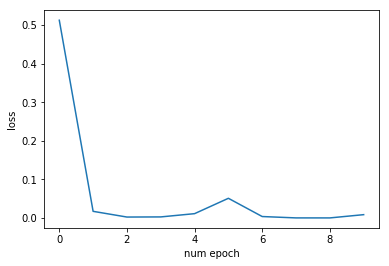

In [267]:
plt.figure()
plt.plot(flag_final)
plt.xlabel('num epoch')
plt.ylabel('loss')
flag_final

Ну не особо улучшилось, но значения ошибок стали чуть поменьше.

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: